In [2]:
library(ISLR)
library(dplyr)
library(lmridge)
library(leaps)
library(glmnet)
library(DAAG)
library(lmvar)
library(MASS)

Importing GEORGIA education data...

In [3]:
# Import
k_read = read.csv("kread.csv")

In [4]:
#convert Farm to binary
k_read = cbind(k_read, 'FARM_BIN' = as.integer(k_read[,'FARM']=='Y'))
k_read = subset(k_read, select = -c(FARM))

## Fill in missing values somehow

We need to fill in missing values, so let's clean the NA values from the data first.

In [5]:
cleaned_read = k_read[complete.cases(k_read),]
cleaned_read = subset(cleaned_read, select = -c(ID.))

##get rows which correspond to NA vals

R_na = subset(k_read,is.na(R.SCORE))
L_na = subset(k_read,is.na(L.SCORE))

#drop columsn with NAs to create test set

R_test = subset(R_na, select= -c(R.SCORE,ID.))
L_test = subset(L_na, select = -c(L.SCORE,ID.))

##Use R Score, DIEBLS, INP, FARM_BIN to predict L Score
##Use L Score, DIEBELS, INP, FARM_BIN to predict R score

Create a train/test set since we want to figure out if an lm model will be any good in predicting L.SCORE/R.SCORE. We are doing this since we don't have any actualy groundtruth labels for the NA values, and want to see how good this model is.

In [6]:

num_rows = c(1:nrow(cleaned_read)) ##CONSTANT
set.seed(0)
sampled = sample(num_rows) 
test_size = .20*nrow(cleaned_read) ##CONSTANT
train_size = nrow(cleaned_read)-test_size ##CONSTANT
train_index = sampled[1:train_size] ##CONSTANT
test_index = sampled[(train_size + 1): nrow(cleaned_read)] ##CONSTANT

train_set = cleaned_read[train_index,]
test_set = cleaned_read[test_index,]


In [7]:
train_set

,R.SCORE,L.SCORE,DIEBLS,INP,FARM_BIN
,<int>,<int>,<int>,<int>,<int>
157,14,18,33,0,1
78,17,18,16,0,0
182,20,21,42,0,0
144,18,20,30,0,1
177,20,20,38,0,0
50,14,10,8,1,1
15,9,11,0,1,0
61,14,9,12,1,0
97,16,21,20,0,0


Fit the models on the train set using all variables other than R.Score/L.Score. This is probably not best practice because were are trying to predict DIEBELS with R.Score/L.Score

In [8]:
model_R = lm(R.SCORE~.,train_set, x = TRUE,y= TRUE)
model_L =lm(L.SCORE~.,train_set, x= TRUE, y= TRUE)

Creating custom scoring metrics for the cross validations

In [9]:
rsqd = function(object, y, X){
    preds = predict(object, as.data.frame(X))
    tss = sum((y-mean(y))%*%(y-mean(y)))
    rss = sum((y-preds)%*%(y-preds))
    rsq = 1 - (rss/tss)
    return(rsq)
    }
rse = function(object,y,X){
    preds = predict(object, as.data.frame(X))
    rss = sum((y-preds)%*%(y-preds))
    rse = sqrt(rss/(length(y)-(length(coefficients(object)-1))))
    return(rse) 
}

Run 5 fold CV on built-in metrics as well as rsqd custom metric

In [10]:
cv_R_rsq = cv.lm(object = model_R, k = 5, fun = rsqd, seed = 24)
cv_L_rsq = cv.lm(object = model_L, k =5, fun = rsqd, seed = 24)

In [11]:
cv_R_rsq

Mean absolute error        :  2.335835 
Sample standard deviation  :  0.3632365 

Mean squared error         :  10.20601 
Sample standard deviation  :  3.343929 

Root mean squared error    :  3.159387 
Sample standard deviation  :  0.5294868 

User supplied function     :  0.3890505 
Sample standard deviation  :  0.197561 


In [12]:
cv_L_rsq

Mean absolute error        :  2.369548 
Sample standard deviation  :  0.3360425 

Mean squared error         :  9.654316 
Sample standard deviation  :  3.038032 

Root mean squared error    :  3.073806 
Sample standard deviation  :  0.507485 

User supplied function     :  0.4191553 
Sample standard deviation  :  0.1789954 


Rsquard test statistic is around .4 for all models. Rsqared is low, so there isn't too much of a linear relationship here. Shouldn't expect much during testing. Figure out rse below. 

In [13]:
cv_R_rse = cv.lm(object = model_R, k = 5, fun = rsqd, seed = 24)
cv_L_rse = cv.lm(object = model_L, k =5, fun = rse, seed = 24)

Below, RSE is around 3 for both models, which isn't that bad. 

In [14]:
cv_R_rse

Mean absolute error        :  2.335835 
Sample standard deviation  :  0.3632365 

Mean squared error         :  10.20601 
Sample standard deviation  :  3.343929 

Root mean squared error    :  3.159387 
Sample standard deviation  :  0.5294868 

User supplied function     :  0.3890505 
Sample standard deviation  :  0.197561 


In [15]:
cv_L_rse

Mean absolute error        :  2.369548 
Sample standard deviation  :  0.3360425 

Mean squared error         :  9.654316 
Sample standard deviation  :  3.038032 

Root mean squared error    :  3.073806 
Sample standard deviation  :  0.507485 

User supplied function     :  3.405234 
Sample standard deviation  :  0.5622038 


In [16]:
test_preds_R = predict(model_R, subset(test_set,select = -c(R.SCORE)))
test_preds_L = predict(model_L, subset(test_set,select = -c(L.SCORE)))

Compute the RSE and R^2 statistics. 

In [17]:
y_R = test_set[,'R.SCORE']
y_L = test_set[,'L.SCORE']
rss_R = sum((test_preds_R -y_R)%*%(test_preds_R-y_R))
rss_L = sum((test_preds_L-y_L)%*%(test_preds_L-y_L))
tss_R = sum((y_R -mean(y_R))%*%(y_R-mean(y_R)))
tss_L = sum((y_L-mean(y_L))%*%(y_L-mean(y_L)))

rsq_R = 1 - rss_R/tss_R
rsq_L = 1 - rss_L/tss_L

rse_R = sqrt(rss_R/(length(y_L)-2))
rse_L = sqrt(rss_L/(length(y_L)-2))

In [18]:
c(rsq_R,rsq_L,rse_R,rse_L)

[1] 0.3580596 0.6370198 4.1099448 2.7112142

We replace NA values with our predictions. 

In [19]:
R_score_pred = predict(model_R, subset(R_na, select = -c(R.SCORE, ID.)) )
L_score_pred = predict(model_L, subset(L_na, select = -c(L.SCORE, ID.)))

##insert predicted values
R_na[,'R.SCORE'] = round(R_score_pred)
L_na[,'L.SCORE'] = round(L_score_pred)
#reset cleaned data variable
cleaned_read = k_read[complete.cases(k_read),]
#combine data frames
filled_read = rbind(cleaned_read, R_na)
filled_read = rbind(filled_read, L_na)

In [20]:
filled_read

,ID.,R.SCORE,L.SCORE,DIEBLS,INP,FARM_BIN
,<int>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,6,2,0,1,1
2,2,11,3,0,1,1
3,3,7,5,0,1,1
4,4,10,5,0,1,1
6,6,0,7,0,1,1
7,7,19,7,0,1,1
8,8,14,8,0,1,1
9,9,14,8,0,1,1
10,10,12,9,0,1,1


In [21]:
#reset row names
rownames(filled_read) <- 1:nrow(filled_read)

This isn't good pracice though, maybe a better thing to do would just be to regress R.Score on L.Score. Let's see if there is some natural relationship between R.Score and L.Score. The graph below is less than exciting,but still shows a linear trend. Let's use R.Score to predict L.Score, and throug this relationship, we can determine R.Score through the coefficients by working backwards. 

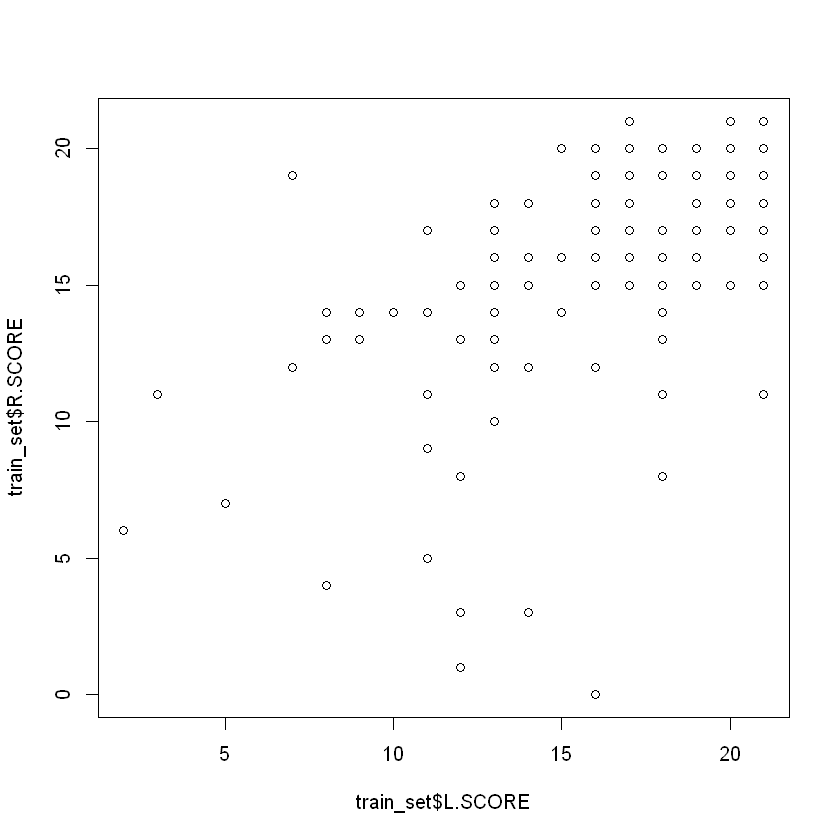

In [22]:
plot(train_set$L.SCORE, train_set$R.SCORE)

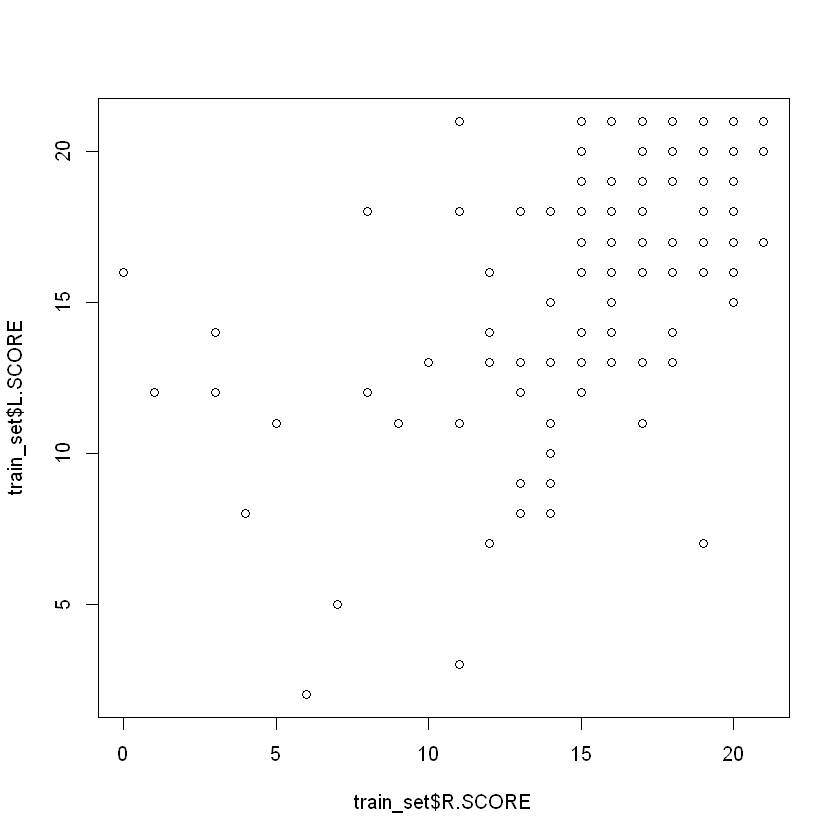

In [23]:
plot(train_set$R.SCORE, train_set$L.SCORE)

Fit the model and run CV validation on model_R_new

In [24]:
model_R_new =lm(R.SCORE~L.SCORE, train_set, x = TRUE,y= TRUE)
model_L_new = lm(L.SCORE~R.SCORE, train_set, x = TRUE, y= TRUE)

In [25]:
cv_R_new_rsqd = cv.lm(object = model_R_new, k = 5, fun = rsqd, seed = 24)
cv_R_new_rse = cv.lm(object = model_R_new, k = 5, fun = rse, seed = 24)

In [26]:
cv_R_new_rsqd ##considerably worse than before

Mean absolute error        :  2.476237 
Sample standard deviation  :  0.3516305 

Mean squared error         :  12.37 
Sample standard deviation  :  4.007563 

Root mean squared error    :  3.476131 
Sample standard deviation  :  0.5984562 

User supplied function     :  0.2781961 
Sample standard deviation  :  0.1640992 


In [27]:
cv_R_new_rse

Mean absolute error        :  2.476237 
Sample standard deviation  :  0.3516305 

Mean squared error         :  12.37 
Sample standard deviation  :  4.007563 

Root mean squared error    :  3.476131 
Sample standard deviation  :  0.5984562 

User supplied function     :  3.612501 
Sample standard deviation  :  0.6219339 


In [28]:
model_R_new$coefficients
model_L_new$coefficients ##get coefficients, since it is probably better to use a model whose covariate does not include diebls

(Intercept)     L.SCORE 
  5.5014957   0.6260345

(Intercept)     R.SCORE 
  7.1418679   0.5840533

In [29]:
test_preds_R_new = predict(model_R_new, subset(test_set,select = -c(R.SCORE)))

Test scores

In [30]:
rss_R_new = sum((test_preds_R_new -y_R)%*%(test_preds_R_new-y_R))
tss_R_new = sum((y_R -mean(y_R))%*%(y_R-mean(y_R)))
rsq_R_new = 1 - rss_R_new/tss_R_new
rse_R_new = sqrt(rss_R_new/(length(y_R)-2))

In [31]:
c(rss_R_new,tss_R_new,rsq_R_new,rse_R_new)

[1] 505.1414962 842.0294118   0.4000904   3.9731186

Get rss_R for comparison

In [32]:
RSS_r_new = sum((model_R_new$residuals)^2)
RSS_r = sum((model_R$residuals)^2)

In [33]:
RSS_r_new

[1] 1604.545

In [34]:
RSS_r

[1] 1263.214

Let's quickly do a model comparison between model_R_new and model_R. We have $\frac{(RSS_0 - RSS_1)/(p-p_0)}{RSS_1/(n-p-1)} \sim F_{p-p_0,n-p-1}$, where the $0$ subscripts refer to model_R_new.

We have rss_R_new = $RSS_0$ = 1604.54526872071 and rss_R =1263.21423558875 = $RSS_1$. We also have $p_0 = 1$, $p = 4$ and $n = 136$. Computing our test stat, we have $\frac{(1604.54526872071 - 1263.21423558875)/(3)}{1263.21423558875/(136-4-1)} = -.6328$. We have $F_{3, 29}$, so we compute the test stat with $\alpha = 0.05$.

In [35]:
f_stat = ((RSS_r_new - RSS_r)/3)/(RSS_r/131)

In [36]:
f_stat

[1] 11.7991

In [37]:
pf(11.799,3,29,lower = FALSE)

[1] 3.172907e-05

We therefore reject the null, and believe that the relationship is better explained with the alternative model. Of course, I don't think we should use the alternative model. We will use the other one. 

Let's get our predictions and replace the NA vals with them. 

In [38]:
R_new_preds = predict(model_R_new, subset(R_na, select = -c(R.SCORE, ID.)) )
L_new_preds = predict(model_L_new, subset(L_na, select = -c(L.SCORE, ID.)))

##insert predicted values
R_na[,'R.SCORE'] = round(R_new_preds)
L_na[,'L.SCORE'] = round(L_new_preds)
#reset cleaned data variable
cleaned_read = k_read[complete.cases(k_read),]
#combine data frames
filled_read = rbind(cleaned_read, R_na)
filled_read = rbind(filled_read, L_na)
rownames(filled_read) <- 1:nrow(filled_read)

Alright, we'll use this one. I don't know how bad of practice it is to regress two variables on eachother, but this is better I believe than attempting to use DIEBLS to predict R.SCORE/L.SCORE."filled_read" is our new data frame with non-na values.

In [39]:
head(filled_read)

,ID.,R.SCORE,L.SCORE,DIEBLS,INP,FARM_BIN
,<int>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,6,2,0,1,1
2,2,11,3,0,1,1
3,3,7,5,0,1,1
4,4,10,5,0,1,1
5,6,0,7,0,1,1
6,7,19,7,0,1,1


## Check if there is any statistical difference between RScore LScore by group

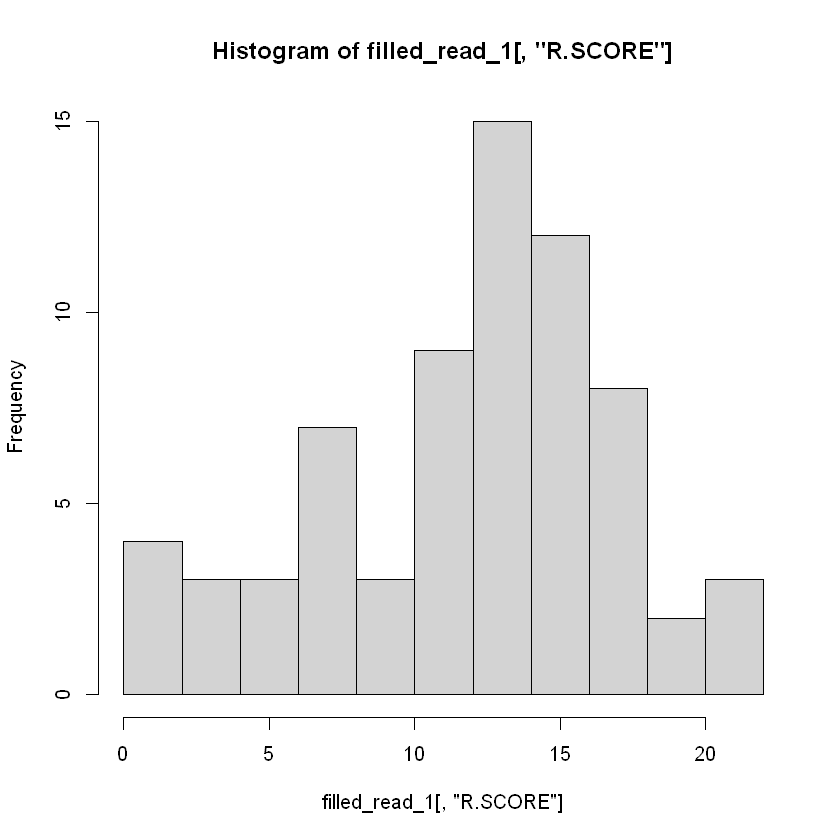

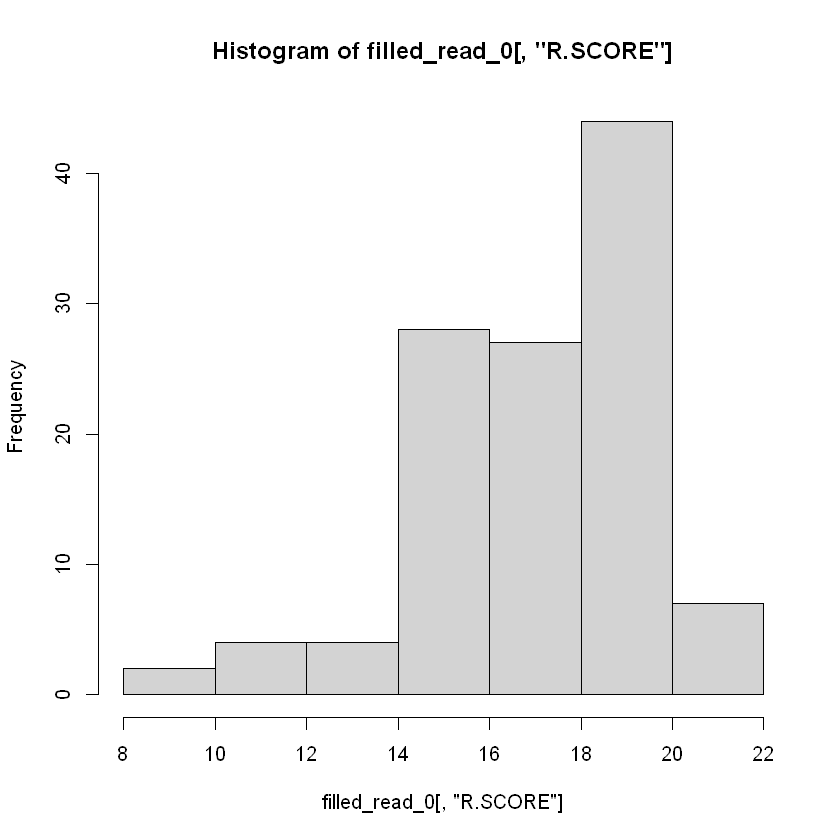

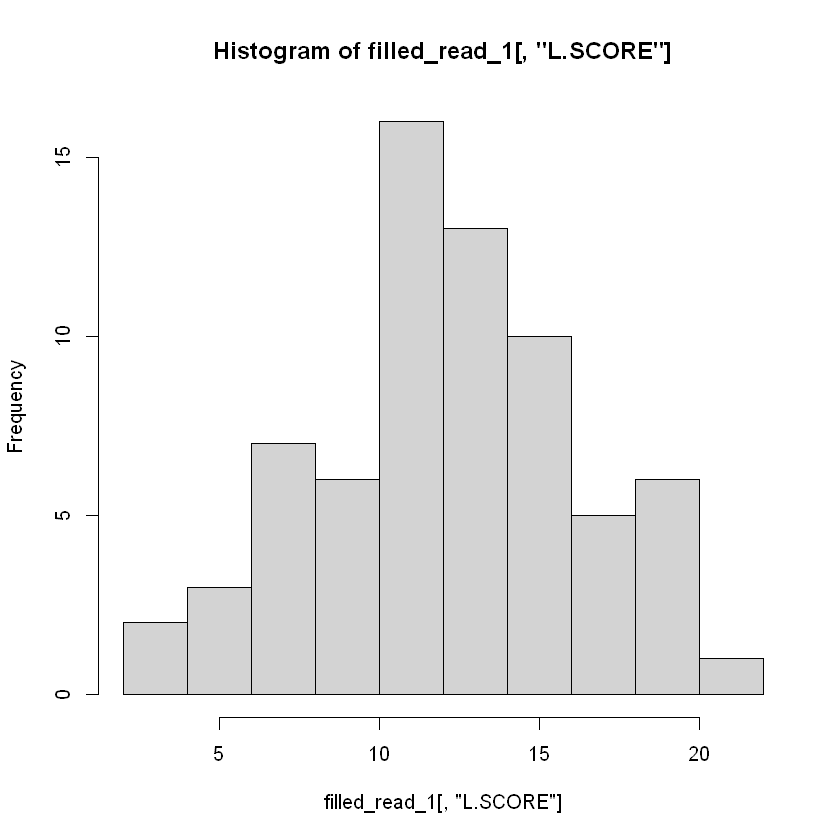

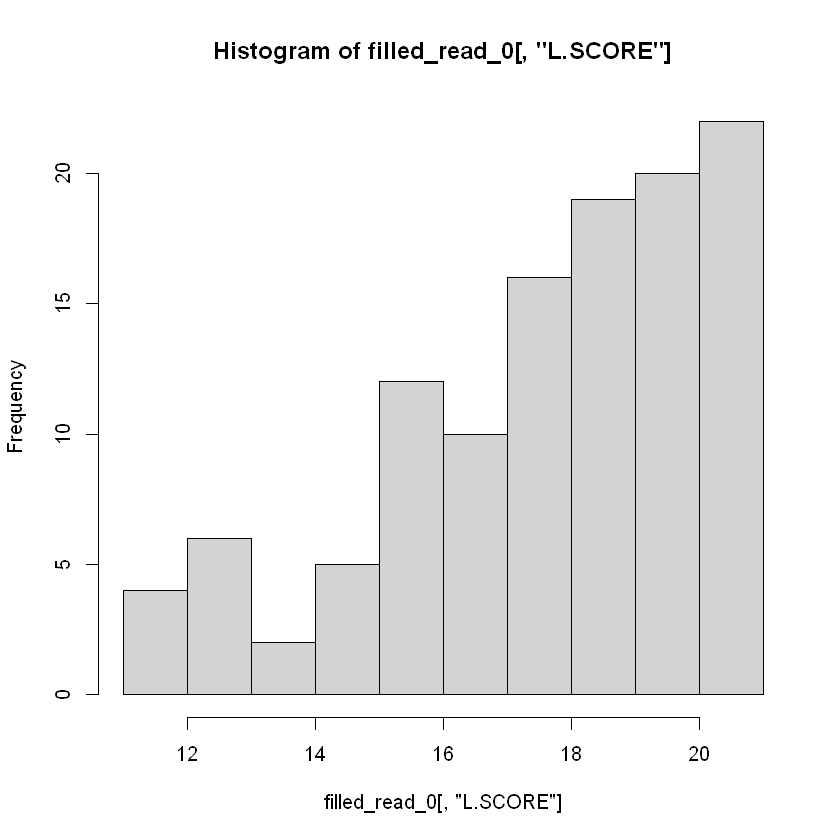

In [40]:
##using filled_read

filled_read_1 = filled_read[filled_read['INP']==1,]
filled_read_0 = filled_read[filled_read['INP']==0,]

##check normality 

hist(filled_read_1[,'R.SCORE'])
hist(filled_read_0[,'R.SCORE'])
hist(filled_read_1[,'L.SCORE'])
hist(filled_read_0[,'L.SCORE'])

All of these look approximately normal, except the last histogram. While it might be bad practice to run t-tests on the last one it's not a crazy assumption to believe that the reading scores of a pre-kindergarten population will be asymptotically normal

For the t-tests below, we have natural assumption that those with greater reading score belong in the group that don't find placement 

In [41]:
t.test(filled_read_0[,'R.SCORE'],filled_read_1[,'R.SCORE'], alternative = 'greater')
t.test(filled_read_0[,'L.SCORE'], filled_read_1[,'L.SCORE'], alternative = 'greater')


	Welch Two Sample t-test

data:  filled_read_0[, "R.SCORE"] and filled_read_1[, "R.SCORE"]
t = 7.9135, df = 87.474, p-value = 3.597e-12
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 4.136328      Inf
sample estimates:
mean of x mean of y 
 17.48276  12.24638 



	Welch Two Sample t-test

data:  filled_read_0[, "L.SCORE"] and filled_read_1[, "L.SCORE"]
t = 9.8546, df = 97.967, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 4.563974      Inf
sample estimates:
mean of x mean of y 
 18.11207  12.62319 


With a 95% confidence level, in both, we have p-values which are **significantly** less than 0.05. We should expect good predictive power using R.SCORE and L.SCORE to predict DIEBLS. 

In [42]:
wilcox.test(filled_read_0[,'R.SCORE'], y = filled_read_1[,'R.SCORE'], alternative = 'greater')


	Wilcoxon rank sum test with continuity correction

data:  filled_read_0[, "R.SCORE"] and filled_read_1[, "R.SCORE"]
W = 6671.5, p-value = 1.332e-14
alternative hypothesis: true location shift is greater than 0


In [43]:
wilcox.test(filled_read_0[,'L.SCORE'], filled_read_1[,'L.SCORE'],alternative = 'greater')


	Wilcoxon rank sum test with continuity correction

data:  filled_read_0[, "L.SCORE"] and filled_read_1[, "L.SCORE"]
W = 6933.5, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


In [44]:
length(filled_read_0[,'R.SCORE'])

[1] 116

In [45]:
length(filled_read_1[,'R.SCORE'])

[1] 69

## Model Selection

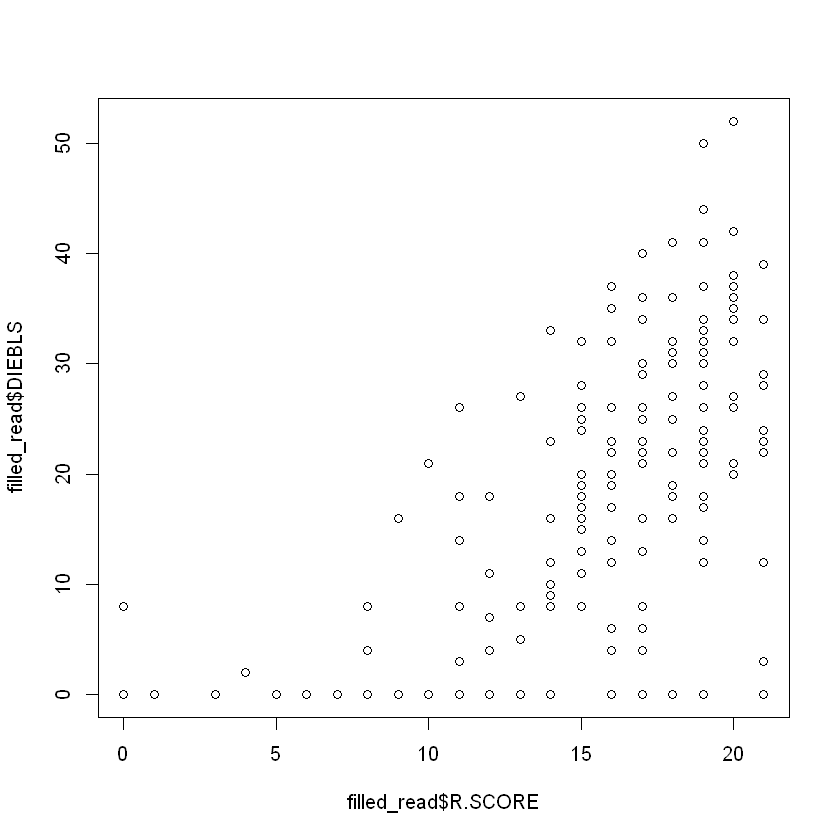

In [46]:
plot(filled_read$R.SCORE, filled_read$DIEBLS) #weak positive linear trend except for all the 0's

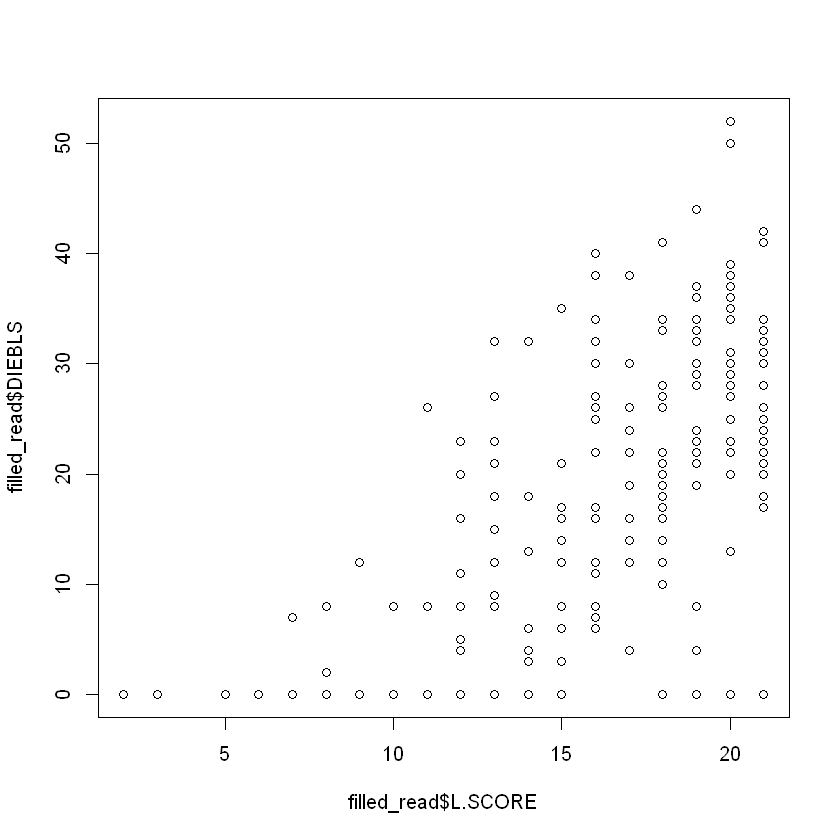

In [47]:
plot(filled_read$L.SCORE, filled_read$DIEBLS) #weak positive linear trend except for the 0s

### Full model

Let's fit the full model first, using R.SCORE, L.SCORE, INP, and FARM_BIN, and see how good of covariates these are. Here, we are using "filled_read". First, remove the ID column and call this "features_full".

In [48]:
features_full= subset(filled_read, select = -c(ID.,INP)) ##create features matrix from filled_read

In [49]:
INP = filled_read$INP

We use the constants from earlier for the indices/sizes. We'll set a different seed though. 

In [50]:
invisible(num_rows) ##CONSTANT
set.seed(1) #different seed
sampled_fill = sample(num_rows) 
invisible(test_size) ##CONSTANT
invisible(train_size) ##CONSTANT
train_index_fill = sampled_fill[1:train_size] 
test_index_fill = sampled_fill[(train_size + 1): nrow(cleaned_read)] ##CONSTANT

train_set_fill = features_full[train_index_fill,]  #train and test sets 
test_set_fill = features_full[test_index_fill,] 

In [51]:
filled_read[test_index_fill,]$INP

[1] 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0

In [53]:
INP_train = filled_read[train_index_fill,]$INP
INP_test = filled_read[test_index_fill,]$INP

We have separated our train/test sets, so let's use CV to determine the validation errors of a full model first. We'll feed in both RSS and RSE as scoring metrics, setting a seed to maintain that we're getting the same folds. 

In [54]:
full_fit = lm(DIEBLS~., train_set_fill, x = TRUE, y = TRUE)

In [55]:
cv_full_rsqd = cv.lm(full_fit, k = 5, fun = rsqd, seed = 23) ##set different seed 

In [56]:
cv_full_rse = cv.lm(full_fit,  k = 5, fun = rse, seed = 23)

In [57]:
##Mean R^2 is 45%! Not much variance explained. 
cv_full_rsqd

Mean absolute error        :  7.717329 
Sample standard deviation  :  0.8457575 

Mean squared error         :  91.45073 
Sample standard deviation  :  18.81876 

Root mean squared error    :  9.522736 
Sample standard deviation  :  0.9799461 

User supplied function     :  0.4528572 
Sample standard deviation  :  0.112877 


In [58]:
##Mean RS is 9. Note great. 
cv_full_rse

Mean absolute error        :  7.717329 
Sample standard deviation  :  0.8457575 

Mean squared error         :  91.45073 
Sample standard deviation  :  18.81876 

Root mean squared error    :  9.522736 
Sample standard deviation  :  0.9799461 

User supplied function     :  10.31762 
Sample standard deviation  :  1.061745 


Let's predict on our test test, compute R^2, RSS, RSE, MSE, and TSS. 

In [59]:
preds_full = predict(full_fit, subset(test_set_fill, select = -c(DIEBLS)))
RSS_full = (preds_full - test_set_fill$DIEBLS)%*%(preds_full-test_set_fill$DIEBLS)
TSS_full = (test_set_fill$DIEBLS - mean(test_set_fill$DIEBLS))%*%(test_set_fill$DIEBLS- mean(test_set_fill$DIEBLS))
R2_full = 1 - RSS_full/TSS_full
RSE_full = sqrt(RSS_full/(length(preds_full) - length(coefficients(full_fit)-1)))
MSE_full = RSS_full/length(preds_full)

In [60]:
full_fit_coef = coef(full_fit)

In [61]:
full_fit_coef

(Intercept)      R.SCORE      L.SCORE     FARM_BIN 
-18.91319055   1.15634800   1.23235286   0.01713377

In [62]:
full_stats = c(RSS_full, TSS_full, R2_full, RSE_full, MSE_full) 

In [63]:
full_stats ##R^2 on test set is 50%

[1] 2860.4747198 5824.5000000    0.5088892    9.7646893   84.1316094

After making our predictions, we now check if we accurately predicted the INP for students. 

In [151]:
sum(as.integer(preds_full <= 13)) #how many did we enroll in extra help

[1] 7

In [160]:
inp_pred = as.integer(preds_full <= 13) ##assign the binary vector of INP

In [161]:
INP_test #check the actual INP assignments

[1] 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0

In [162]:
sum(as.integer(inp_pred == INP_test)) #how many did we assign correctly?

[1] 29

In [163]:
29/34 #what is our percentage?

[1] 0.8529412

In [136]:
preds_full

92        146        112         62         11         57         66 
 24.024554  26.413255  24.024554  25.256907   7.210509  15.684970  22.868206 
       130         97         91         30        114          8          9 
 27.721612  26.565264  22.775067  23.872544  28.936832   7.151638   6.071295 
       128        155        157          5         95         32         96 
 25.332912  26.548131  23.020216 -10.269587  24.176564  15.550094  28.801956 
        50         12         88          4         94         38         63 
  9.768354  -6.572528  22.944211  -1.170812  23.020216  19.230018  14.452617 
        56        170        117         71        136        152 
 21.787863  28.877960  21.635853  19.306023  16.841318  18.090804

### Ridge

Next, let's use lasso and ridge models to penalize some of the covariates. First, ridge.

In [166]:
lambdas = 10^seq(6, -6, by = -.1)
set.seed(0)
ridge_cv = cv.glmnet(as.matrix(subset(train_set_fill, select = -c(DIEBLS))), as.matrix(train_set_fill$DIEBLS), alpha = 0, lambda  = lambdas)

In [167]:
ridge_cv$lambda.min

[1] 1

In [168]:
set.seed(0)
ridge_fit <- glmnet(as.matrix(subset(train_set_fill, select = -c(DIEBLS))),as.matrix(train_set_fill$DIEBLS), alpha = 0, lambda = ridge_cv$lambda.min)

In [169]:
#Get RSS

In [170]:
rid_fit_coef = coef(ridge_fit)

Let's compute R^2, RSS, RSE, MSE, TSS. 

In [171]:
preds_ridge = predict(ridge_fit, as.matrix(subset(test_set_fill, select = -c(DIEBLS))))
RSS_rid = (as.vector(preds_ridge) - test_set_fill$DIEBLS)%*%(as.vector(preds_ridge)-test_set_fill$DIEBLS)
TSS_rid = (test_set_fill$DIEBLS - mean(test_set_fill$DIEBLS))%*%(test_set_fill$DIEBLS- mean(test_set_fill$DIEBLS))
R2_rid = 1 - RSS_rid/TSS_rid
RSE_rid = sqrt(RSS_rid/(length(preds_ridge)-length(coefficients(ridge_fit)-1)))
MSE_rid = RSS_rid/length(preds_ridge)

In [172]:
ridge_stats = c(RSS_rid, TSS_rid, R2_rid, RSE_rid, MSE_rid) 

In [173]:
ridge_stats ##R^2 51%

[1] 2853.0415328 5824.5000000    0.5101654    9.7519939   83.9129863

In [178]:
sum(as.integer(preds_ridge <= 13))

[1] 7

In [180]:
inp_pred_ridge = as.integer(preds_ridge <= 13) #assign binary vector for INP

In [183]:
sum(as.integer(inp_pred_ridge == INP_test)) #how many did we get correct

[1] 29

In [182]:
29/34 #correct percentage

[1] 0.8529412

In [184]:
as.integer(preds_ridge <= 13) == as.integer(preds_full <= 13) ##same predictions as the full model

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE

In [186]:
preds_ridge #our DIEBLS predictions

,s0
92,23.6559324
146,25.9229901
112,23.6559324
62,24.8271193
11,7.9730247
57,16.0207005
66,22.5600617
130,27.1694930
97,26.0736223
91,22.7465573


### LASSO

Let's run a LASSO model. It will be interesting to see if it reduces FARM to 0 for later analysis when we do model accuracy tests. 

In [187]:
lambdas = 10^seq(6, -6, by = -.1) ##same lambdas
set.seed(0) ##same seed
lasso_cv = cv.glmnet(as.matrix(subset(train_set_fill, select = -c(DIEBLS))), as.matrix(train_set_fill$DIEBLS), alpha = 1, lambda  = lambdas)

In [188]:
lasso_cv$lambda.min

[1] 0.3981072

In [189]:
set.seed(0)
lasso_fit =  glmnet(as.matrix(subset(train_set_fill, select = -c(DIEBLS))),as.matrix(train_set_fill$DIEBLS), alpha = 1, lambda = lasso_cv$lambda.min)

In [190]:
## GEt RSS/RSE

In [191]:
lass_fit_coef =  coef(lasso_fit) 

In [192]:
lass_fit_coef #FARM reduced to 0

4 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept) -17.022647
R.SCORE       1.098742
L.SCORE       1.172488
FARM_BIN      .       

In [193]:
preds_lasso = predict(lasso_fit, as.matrix(subset(test_set_fill, select = -c(DIEBLS))))
RSS_las = (as.vector(preds_lasso) - test_set_fill$DIEBLS)%*%(as.vector(preds_lasso)-test_set_fill$DIEBLS)
TSS_las = (test_set_fill$DIEBLS - mean(test_set_fill$DIEBLS))%*%(test_set_fill$DIEBLS- mean(test_set_fill$DIEBLS))
R2_las= 1 - RSS_las/TSS_las
RSE_las = sqrt(RSS_las/(length(preds_lasso)-length(coefficients(lasso_fit)-1)))
MSE_las = RSS_las/length(preds_lasso)

In [194]:
lasso_stats = c(RSS_las, TSS_las, R2_las, RSE_las, MSE_las) 

In [195]:
lasso_stats ##R2 still around 51%

[1] 2851.5343882 5824.5000000    0.5104242    9.7494177   83.8686585

### Test Results

Create a results data frame for all test scores

In [196]:
results = data.frame(full_stats, ridge_stats, lasso_stats)

In [197]:
rownames(results) <- c("RSS", "TSS", "R2", "RSE", "MSE")

In [198]:
results ##super similar (TSS is obviously the same for all), although the R2, MSE, RSS, RSE are just marginally better

,full_stats,ridge_stats,lasso_stats
,<dbl>,<dbl>,<dbl>
RSS,2860.4747198,2853.0415328,2851.5343882
TSS,5824.5000000,5824.5000000,5824.5000000
R2,0.5088892,0.5101654,0.5104242
RSE,9.7646893,9.7519939,9.7494177
MSE,84.1316094,83.9129863,83.8686585


Create data frame with all coefficients

In [199]:
results = data.frame(as.vector(full_fit_coef), as.vector(rid_fit_coef), as.vector(lass_fit_coef))

colnames(results) = c("full", "ridge","lasso")
rownames(results) = c("Int", "RSCORE", 'LSCORE', 'FARMBIN')

In [200]:
results

as.vector.full_fit_coef.,as.vector.rid_fit_coef.,as.vector.lass_fit_coef.
<dbl>,<dbl>,<dbl>
-18.91319055,-16.8139770,-17.022647
1.15634800,1.0958708,1.098742
1.23235286,1.1711869,1.172488
0.01713377,-0.2618117,0.000000


### Testing on Marginal Effect/Model Accuracy for FARM

We already know LASSO reduced FARM to 0. Our test on marginal effect can be found in summary tables. We can then compared accuracy between models within full/ridge. If we were to compute marginal manually for both models, our hypotheses are as follows: <br>

$H_0: \beta_{FARM} = 0$ versus $H_1: \beta_{FARM} \neq 0$. 

For full model, we have $\hat{\sigma} = RSE_{full} = 9.4546198$ and for ridge model, we have $\hat{\sigma} = RSE_{ridge} = 9.4423275$. In both cases, we need to compute $\sqrt{\nu_j}$ which is the third diagonal entry in $(X^{T}X)^{-1}$, our train features matrix with added intercept.Our test statistic for both models will be $t = \frac{\hat{\beta}_{FARM}}{\sqrt{\nu_{FARM}}RSE} \sim t_{n-p-1} = t_{136-3-1} = t_{132}$. But instead of doing this for the full, we can use summary.

In [201]:
summary(full_fit)


Call:
lm(formula = DIEBLS ~ ., data = train_set_fill, x = TRUE, y = TRUE)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.5653  -6.3297   0.4297   6.5737  22.2955 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -18.91319    4.01468  -4.711 6.16e-06 ***
R.SCORE       1.15635    0.23264   4.971 2.03e-06 ***
L.SCORE       1.23235    0.23597   5.223 6.69e-07 ***
FARM_BIN      0.01713    1.70673   0.010    0.992    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.342 on 132 degrees of freedom
Multiple R-squared:  0.496,	Adjusted R-squared:  0.4846 
F-statistic: 43.31 on 3 and 132 DF,  p-value: < 2.2e-16


Since $.992 > .05$ we fail the reject the hypothesis that FARMBIN is $0$. Let's now compute the test stat for ridge. 

In [202]:
features = subset(train_set_fill, select = -c(DIEBLS))

In [203]:
features_inter = cbind(intercept = rep(1,136), features)

In [204]:
solve(as.matrix(t(features_inter))%*%as.matrix(features_inter))

,intercept,R.SCORE,L.SCORE,FARM_BIN
intercept,0.184664153,-0.0045825060,-0.0051293269,-0.0397955442
R.SCORE,-0.004582506,0.0006200687,-0.0003491395,0.0010932296
L.SCORE,-0.005129327,-0.0003491395,0.0006379494,0.0002767817
FARM_BIN,-0.039795544,0.0010932296,0.0002767817,0.0333741279


We retrieve the 3rd diagonal (0-3 indexing). And so we have $\nu_{FARM} = 0.0333741279$. 

For the ridge model: 

In [207]:
t = (-0.2618117)/(sqrt(0.0333741279)*RSE_rid)

In [208]:
pt(-.153224, 132)

[1] 0.4392278

We fail to reject the hypothesis that FARM is 0.

### Next we compare accuracy of models on training using F-test. 

Really, we should only do this for the full model, since both ridge and lasso penalize coefficients to reduce error. We already have the full model (full_fit). Let's train another model without using FARM. 

In [162]:
fit_no_farm = lm(DIEBLS~., subset(train_set_fill, select = -c(FARM_BIN)), x = TRUE, y = TRUE)

In [163]:
rss_no_farm = sum((residuals(fit_no_farm))^2)

In [164]:
rss_no_farm

[1] 11521.06

In [180]:
fit_full = lm(DIEBLS~., train_set_fill, x = TRUE, y = TRUE)

In [181]:
rss_full = sum((residuals(fit_full))^2)

In [182]:
rss_full

[1] 11521.06

In [183]:
# follows f_(p-po,n-p-1) = f_(1,132) distribution
F = (rss_no_farm - rss_full)/(rss_full/(132))

In [185]:
qf(.025,1,132, lower = TRUE)

[1] 0.0009857998

We keep FARM BIN and REJECT the null, since $.0001 < .000985$.

In [186]:
anova(fit_no_farm, fit_full)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,133,11521.06,NA,NA,NA,NA
2,132,11521.06,1,0.008796215,0.0001007807,0.9920054
